# Goal

The goal of this notebook is to perform automatic segmentation.

- get only the brain
- perform automatic segmentation

Realized that this is extremely difficult so changing tactics and I am going to do it for each slice.

This is done and it can be seen in the folder **JPG Stack Cortex Segmentation** located here:
- **C:\Cerebral\_MarioSandBox\DB\medicalHolography\Animal Brains\Monkey\JPG Stack Cortex Segmentation**

# Background

- [DB](http://www.chimpanzeebrain.org/mri-datasets-for-direct-download)
- [Simple ITK Image Basics](http://simpleitk.github.io/SimpleITK-Notebooks/01_Image_Basics.html)

I will try to following these VTK and ITK tutorials:
- [Image Segmentation with Python and SimpleITK](https://pyscience.wordpress.com/2014/10/19/image-segmentation-with-python-and-simpleitk/)
    - [Jupyter notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/somada141/pyscience/raw/master/20141001_SegmentationSimpleITK/Material/SegmentationSimpleITK.ipynb)
    
Articles to read:
- [MRI Segmentation of the Human Brain: Challenges, Methods, and Applications](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4402572/)
- [Automatic Segmentation of Newborn Brain MRI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2945911/)
- [Methods on Skull Stripping of MRI Head Scan Images—a Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4879034/)

# Imports

In [1]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.ndimage
import scipy.misc

In [3]:
from skimage import measure
# for this module the stl is now depricated
# pip install numpy-stl
from stl import mesh

In [4]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Functions

In [5]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [6]:
def showSegmentation(sliceNum=90):
    # Get slice
    idxSlice = sliceNum
    imgOriginal = image[:,:,idxSlice]

    # Apply smoothing
    imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                        timeStep=0.125,
                                        numberOfIterations=5)
    sitk_show(imgSmooth)

    # Get segmentation
    lstSeeds = [(75,60)]

    imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                                  seedList=lstSeeds, 
                                                  lower=0, 
                                                  upper=40,
                                                  replaceValue=labelWhiteMatter)

    # Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
    imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

    # Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
    sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

    # show segmentation
    sitk_show(imgWhiteMatter)

In [7]:
def getMask(sliceImage,pxlRanges):
#     sliceImage = np.copy(grayMatterMask[:,:,50])
    xLen,yLen = np.shape(sliceImage)
#     pxlRanges = grayMatterRange
    lower = pxlRanges[0]
    upper = pxlRanges[1]

    for x in xrange(xLen):
        for y in xrange(yLen):        
            if(sliceImage[x,y]>=lower and sliceImage[x,y]<=upper):                        
                sliceImage[x,y] = 1.0
            else:
                sliceImage[x,y] = 0.0
    
    return sliceImage

In [8]:
def make_mesh(image, threshold=-300, step_size=1):
    print "Transposing surface"
    p = image.transpose(2,1,0)
    
    print "Calculating surface"
    try:
        verts, faces = measure.marching_cubes(p, threshold) 
    except:
        verts, faces = measure.marching_cubes_classic(p, threshold)         
    return verts, faces

# Parameters

In [9]:
inpath = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Monkey//10 sample Chimpanzee 3T for NCBR website//Male_Fritz.nii'
# inpath = "C://Cerebral//_MarioSandBox//DB//medicalHolography//UofT Mouse Brain//C57brain.mnc"

In [10]:
segmentationDir = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Stack Cortex Segmentation//'

In [11]:
gmOutMask = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Mask - Gray Matter//'
gmMasked = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Stack Gray Matter Segmentation//'

wmOutMask = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Mask - White Matter//'
wmMaksed = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//JPG Stack White Matter Segmentation//'

In [12]:
#Note there are 88 slices in the folders
numSlices = 88

# Reading Data

In [13]:
grayMatterMasked = np.zeros((256,256,numSlices))
whiteMatterMasked = np.zeros((256,256,numSlices))

In [14]:
for sliceInd in xrange(numSlices):
    # get gray matter
    grayMatterMasked[:,:,sliceInd] = scipy.ndimage.imread(gmMasked+'{}.jpg'.format(sliceInd))
    
    # get white matter
    whiteMatterMasked[:,:,sliceInd] = scipy.ndimage.imread(wmMaksed+'{}.jpg'.format(sliceInd))

C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


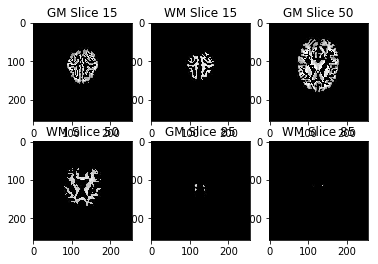

In [15]:
sliceShowInd = [15,50,85]
count = 1

for sInd in sliceShowInd:
    # Slice
    plt.subplot(2,3,count)
    plt.set_cmap("gray")
    plt.imshow(grayMatterMasked[:,:,sInd])
    plt.title('GM Slice {}'.format(sInd))        
    count = count + 1     
    
    plt.subplot(2,3,count)
    plt.set_cmap("gray")
    plt.imshow(whiteMatterMasked[:,:,sInd])
    plt.title('WM Slice {}'.format(sInd))        
    count = count + 1     


So far so good now let us apply the maching cube algorithm

# No segmentation

In [16]:
startSlice = 17
endSlice = 105
sliceInd = range(startSlice,endSlice+1)

In [17]:
data = np.zeros((256,256,len(sliceInd)))

In [18]:
sliceNum = 0
for ind in sliceInd:         
    fileLocation = segmentationDir
    fileName = '{}.jpg'.format(ind)
    img = scipy.ndimage.imread(fileLocation+fileName)
    try:
        data[:,:,sliceNum] = img[:,:,0]
    except:
        data[:,:,sliceNum] = img
    sliceNum = sliceNum+1

C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """


Text(0.5,1,'Showing Slice 85')

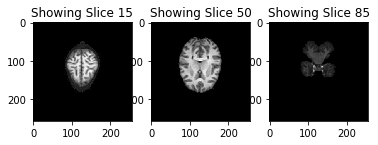

In [19]:
plt.subplot(1,3,1)
sliceShowInd = 15
plt.set_cmap("gray")
plt.imshow(data[:,:,sliceShowInd])
plt.title('Showing Slice {}'.format(sliceShowInd))
plt.subplot(1,3,2)
sliceShowInd = 50
plt.set_cmap("gray")
plt.imshow(data[:,:,sliceShowInd])
plt.title('Showing Slice {}'.format(sliceShowInd))
plt.subplot(1,3,3)
sliceShowInd = 85
plt.set_cmap("gray")
plt.imshow(data[:,:,sliceShowInd])
plt.title('Showing Slice {}'.format(sliceShowInd))

# Marching Cube Algorithm - STL Generation

## Gray Matter

In [20]:
v, f = make_mesh(grayMatterMasked,0.0)

Transposing surface
Calculating surface


In [21]:
grayMesh = mesh.Mesh(np.zeros(f.shape[0], dtype=mesh.Mesh.dtype))

In [22]:
for i, f in enumerate(f):
    for j in range(3):
        grayMesh.vectors[i][j] = v[f[j],:]

In [23]:
outSTLDir = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//STL Files//'
grayMesh.save(outSTLDir+'grayMatter.stl')

## White Matter

In [24]:
v, f = make_mesh(whiteMatterMasked,0.0)

Transposing surface
Calculating surface


In [25]:
whiteMesh = mesh.Mesh(np.zeros(f.shape[0], dtype=mesh.Mesh.dtype))

In [26]:
for i, f in enumerate(f):
    for j in range(3):
        whiteMesh.vectors[i][j] = v[f[j],:]

In [27]:
outSTLDir = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//STL Files//'
whiteMesh.save(outSTLDir+'whiteMatter.stl')

# Entire Brain

In [28]:
v, f = make_mesh(data,0.0)

Transposing surface
Calculating surface


In [29]:
brainMesh = mesh.Mesh(np.zeros(f.shape[0], dtype=mesh.Mesh.dtype))

In [30]:
for i, f in enumerate(f):
    for j in range(3):
        brainMesh.vectors[i][j] = v[f[j],:]

In [31]:
outSTLDir = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//Animal Brains//Monkey//STL Files//'
brainMesh.save(outSTLDir+'brain.stl')